# **Machine-Learning-for-Solar-Energy-Prediction**

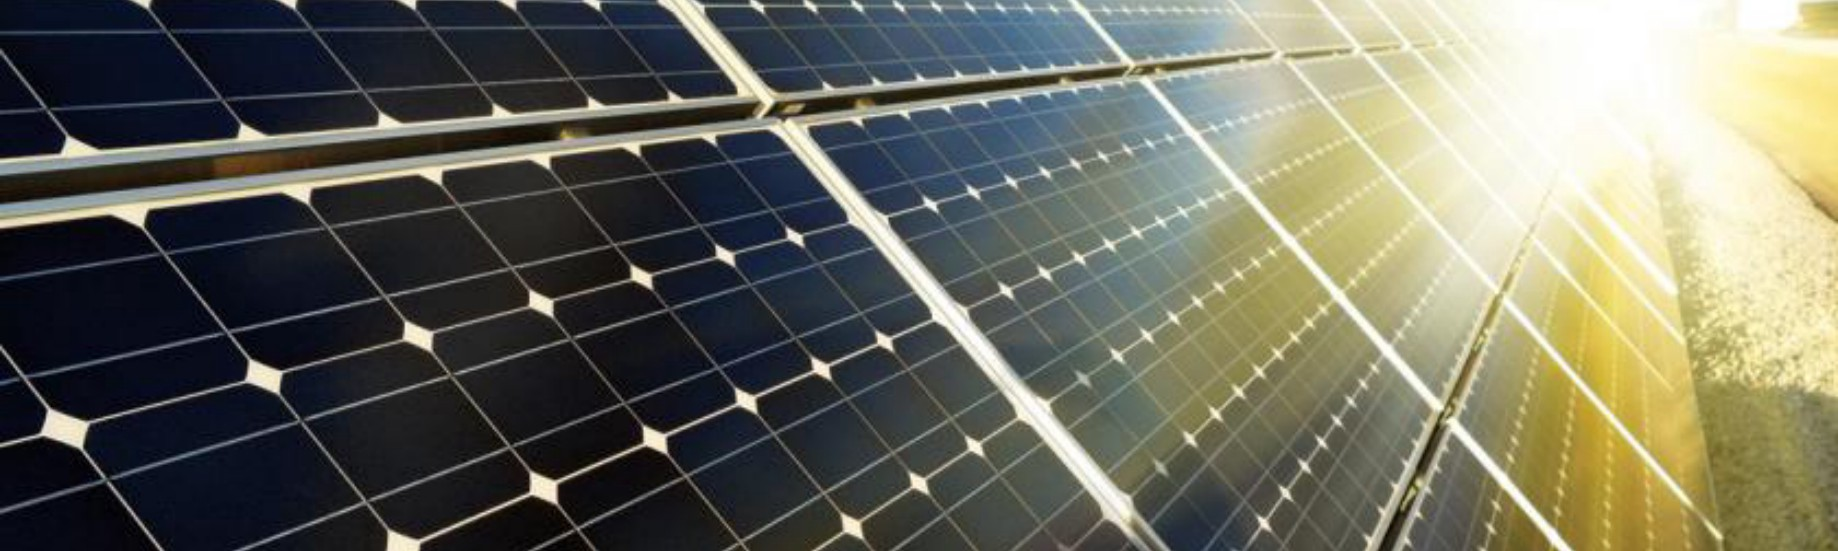

Goal: predict the hourly power production of a photovoltaic power station from the measurements of a set of weather features.

Language: Python

This project could be decomposed in 3 parts:

Data Pre-processing: we processed the raw weather data files (input) from the National Oceanographic and Atmospheric Administration and the power production data files (output) from Urbana-Champaign solar farm to get meaningful numeric values on an hourly basis ;

Feature Selection: we run correlation analysis between the weather features and the energy output to discard useless features, we also implemented Principal Component Analysis to reduce the dimension of our dataset ;

Machine Learning : we compared the performances of our ML algorithms. Implemented models include Weighted Linear Regression with and without dimension reduction, Boosting Regression Trees, and artificial Neural Networks with and without vanishing temporal gradient



# Download Dataset

In [ ]:
!git clone https://github.com/doctorai-in/solar-energy-prediction.git

Cloning into 'solar-energy-prediction'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [ ]:
cd solar-energy-prediction

/content/solar-energy-prediction


In [ ]:
!unzip datasets.zip 

Archive:  datasets.zip
   creating: datasets/
   creating: datasets/hourly/
  inflating: datasets/hourly/weather_dev.csv  
  inflating: datasets/hourly/weather_test.csv  
  inflating: datasets/hourly/weather_train.csv  


# Import Library and Dataset

In [ ]:
import numpy as np
import math
import matplotlib as mpl
from matplotlib.image import imread
from random import randint
import seaborn as sns
%matplotlib inline
import theano
import keras
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
import keras.utils
import keras.layers
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import r2_score
from IPython.display import display
from utils import normalize_data, import_data,  write_to_csv, evaluate, mse

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Dataset Import

In [ ]:
mpl.use('Agg')
import matplotlib.pyplot as plt

DATASET_PATH = "./datasets/hourly/"

* `The time-series for both solar energy and weather parameters starts on February 1, 2016 and ends on October31, 2017`

>Weather feature | Unit |
>--- | --- | 
>Cloud coverage | % Range | 
>Visibility | Miles |
>Temperature | Celcius | 
>Dew point | Celcius | 
>Relative humidity | % | 
>Wind speed | Mph | 
>Station pressure  | inchHg | 
>Altimeter | inchHg | 
>Solar energy | KWh | 

In [ ]:
train_dataframe = pd.read_csv(DATASET_PATH + 'weather_train.csv', sep=",", engine='python', header = 0)
dev_dataframe = pd.read_csv(DATASET_PATH + 'weather_dev.csv', sep=",", engine='python', header = 0)
test_dataframe = pd.read_csv(DATASET_PATH + 'weather_test.csv', sep=",", engine='python', header = 0)
print("Training Dataset : ")
display(train_dataframe.head(5))
print("Test Dataset : ")
display(test_dataframe.head(5))

Training Dataset : 


,Hours,Day,Month,Year,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy
0,12,2,1,2017,1.00,1.85,6.97,6.90,98.24,10.92,29.18,29.97,449.25
1,9,7,2,2016,0.00,10.00,3.96,-0.61,70.20,17.96,29.12,29.91,3165.50
2,9,22,2,2016,0.04,10.00,2.99,-1.34,71.04,10.57,29.37,30.17,2637.00
3,8,3,10,2017,1.00,10.00,21.60,17.14,72.80,11.84,29.53,30.33,710.25
4,7,27,2,2017,1.00,10.00,2.75,0.70,85.40,6.64,29.37,30.17,680.50


Test Dataset : 


,Hours,Day,Month,Year,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy
0,11,27,4,2017,1.00,10.00,8.63,6.21,83.00,16.32,28.91,29.69,1293.75
1,15,9,10,2016,0.00,10.00,24.07,5.90,28.96,9.32,29.47,30.27,3024.50
2,6,10,5,2017,0.73,4.96,13.85,11.99,90.00,5.40,29.16,29.95,241.73
3,8,30,4,2017,1.00,7.33,14.83,14.03,97.60,10.82,28.95,29.73,597.50
4,8,19,3,2017,0.00,10.00,4.61,0.36,73.20,4.40,29.58,30.38,1647.75


# Feature Analysis

In [ ]:
print("Check null values in Training Dataset : \n") 
display(train_dataframe.isnull().sum())
print("\n Check null values in Test Dataset : \n") 
display(test_dataframe.isnull().sum())

Check null values in Training Dataset : 



Hours                0
Day                  0
Month                0
Year                 0
Cloud coverage       0
Visibility           0
Temperature          0
Dew point            0
Relative humidity    0
Wind speed           0
Station pressure     0
Altimeter            0
Solar energy         0
dtype: int64


 Check null values in Test Dataset : 



Hours                0
Day                  0
Month                0
Year                 0
Cloud coverage       0
Visibility           0
Temperature          0
Dew point            0
Relative humidity    0
Wind speed           0
Station pressure     0
Altimeter            0
Solar energy         0
dtype: int64

In [ ]:
print("**************** Identifying categorical and numerical variables *****************")
display(train_dataframe.columns)
display(train_dataframe.dtypes)

**************** Identifying categorical and numerical variables *****************


Index(['Hours', 'Day', 'Month', 'Year', 'Cloud coverage', 'Visibility',
       'Temperature', 'Dew point', 'Relative humidity', 'Wind speed',
       'Station pressure', 'Altimeter', 'Solar energy'],
      dtype='object')

Hours                  int64
Day                    int64
Month                  int64
Year                   int64
Cloud coverage       float64
Visibility           float64
Temperature          float64
Dew point            float64
Relative humidity    float64
Wind speed           float64
Station pressure     float64
Altimeter            float64
Solar energy         float64
dtype: object

In [ ]:
cat_feature = [col for col in train_dataframe.columns if train_dataframe[col].dtypes == "O"]
display(cat_feature)

[]

In [ ]:
num_feature = [col for col in train_dataframe.columns if train_dataframe[col].dtypes != "O"]
display(num_feature)

['Hours',
 'Day',
 'Month',
 'Year',
 'Cloud coverage',
 'Visibility',
 'Temperature',
 'Dew point',
 'Relative humidity',
 'Wind speed',
 'Station pressure',
 'Altimeter',
 'Solar energy']

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(train_dataframe["Solar energy"],color='orange')
plt.subplot(1,2,2)
sns.distplot(train_dataframe["Solar energy"], bins=20, kde=False,color='purple')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [ ]:
rev_stat=train_dataframe["Solar energy"].describe()
print(rev_stat)
# calculating interquartile range
iqr=rev_stat['75%']-rev_stat['25%']
upper=rev_stat['75%']+1.5*iqr
lower=rev_stat['25%']-1.5*iqr
print()
print('The upper and lower bounds for suspected outliers are {} and {}'.format(lower,upper))

count    6028.000000
mean     1796.393600
std      1489.498743
min         0.000000
25%       378.937500
50%      1468.875000
75%      3098.625000
max      4733.250000
Name: Solar energy, dtype: float64

The upper and lower bounds for suspected outliers are -3700.59375 and 7178.15625


# Data visualization

In [ ]:
# Correlation matrix
corrmat = train_dataframe.corr()
fig = plt.figure(figsize = (26, 26))

sns.heatmap(corrmat, vmax = 1, square = True,vmin=-1, fmt='.2f',linewidths=1,cmap = corrmap)
plt.show()

In [ ]:
corrmat

,Hours,Day,Month,Year,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy
Hours,1.00,-0.00,0.00,0.00,0.03,0.17,0.21,0.01,-0.43,0.15,-0.12,-0.07,0.21
Day,-0.00,1.00,-0.02,0.01,-0.00,0.01,0.10,0.12,-0.00,0.03,-0.08,-0.12,-0.01
Month,0.00,-0.02,1.00,-0.23,-0.13,0.12,0.32,0.35,-0.04,-0.25,-0.09,0.14,0.03
Year,0.00,0.01,-0.23,1.00,0.02,0.02,0.03,-0.00,-0.03,0.06,0.05,-0.08,-0.02
Cloud coverage,0.03,-0.00,-0.13,0.02,1.00,-0.38,-0.18,0.03,0.50,0.15,0.12,-0.25,-0.36
Visibility,0.17,0.01,0.12,0.02,-0.38,1.00,0.24,0.05,-0.47,0.04,0.00,0.13,0.35
Temperature,0.21,0.10,0.32,0.03,-0.18,0.24,1.00,0.88,-0.27,-0.16,0.11,-0.18,0.38
Dew point,0.01,0.12,0.35,-0.00,0.03,0.05,0.88,1.00,0.17,-0.22,0.10,-0.27,0.09
Relative humidity,-0.43,-0.00,-0.04,-0.03,0.50,-0.47,-0.27,0.17,1.00,-0.12,0.37,-0.15,-0.55
Wind speed,0.15,0.03,-0.25,0.06,0.15,0.04,-0.16,-0.22,-0.12,1.00,-0.07,-0.29,0.06


count   6028.00
mean    1796.39
std     1489.50
min        0.00
25%      378.94
50%     1468.88
75%     3098.62
max     4733.25
Name: Solar energy, dtype: float64


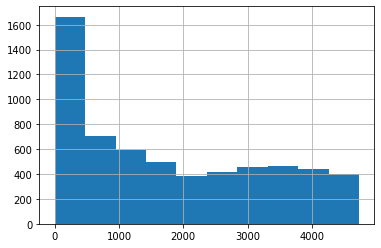

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
print(train_dataframe["Solar energy"].describe())
train_dataframe["Solar energy"].hist()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



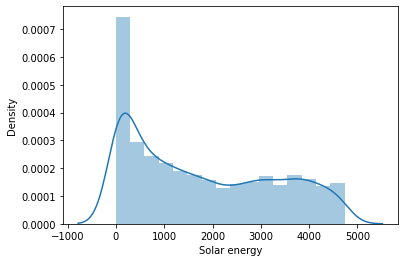

In [ ]:
sns.distplot(train_dataframe['Solar energy']);

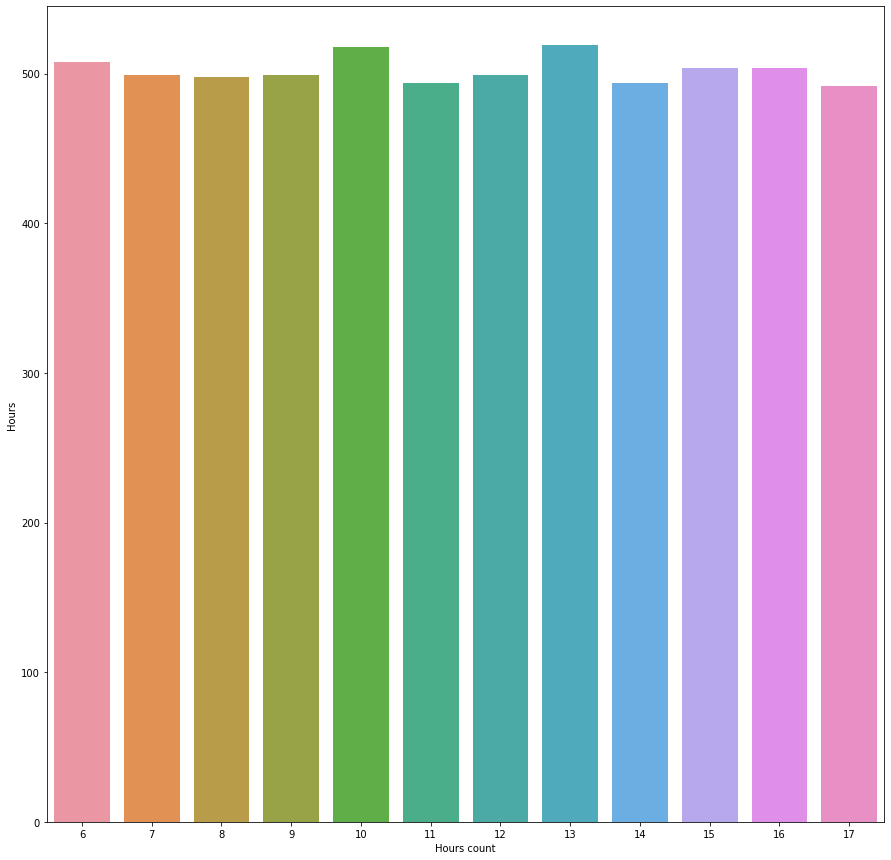

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(x=train_dataframe['Hours'].value_counts().index,y= train_dataframe['Hours'].value_counts().values)
ax.set(ylabel= "Hours Counts",
       xlabel="Hours")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



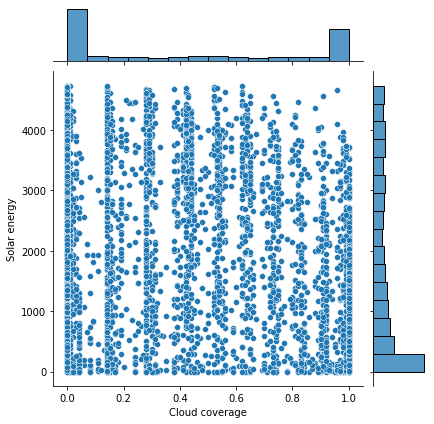

In [ ]:
 
sns.jointplot(train_dataframe["Cloud coverage"], train_dataframe["Solar energy"], kind='scatter')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



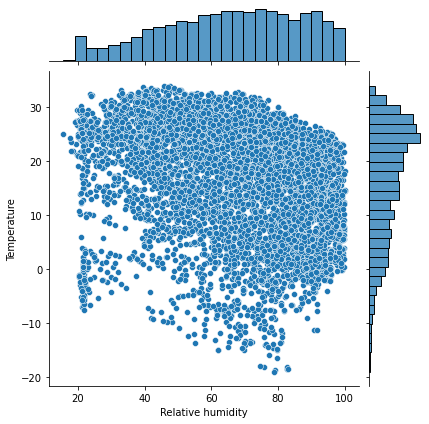

In [ ]:
sns.jointplot(train_dataframe['Relative humidity'] , train_dataframe['Temperature'], kind='scatter')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



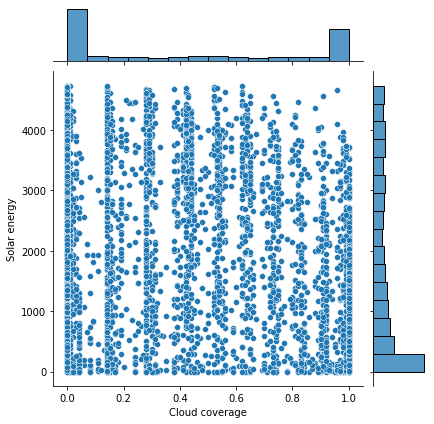

In [ ]:
sns.jointplot(train_dataframe['Cloud coverage'] , train_dataframe['Solar energy'], kind='scatter')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



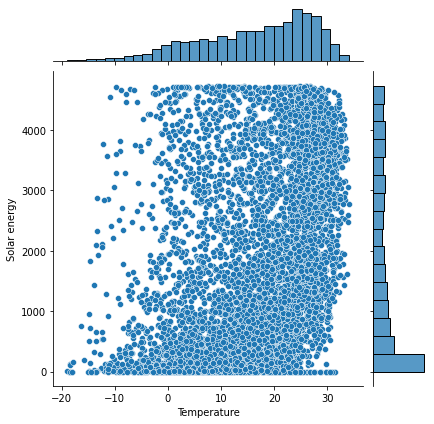

In [ ]:
sns.jointplot(train_dataframe['Temperature'], train_dataframe['Solar energy'], kind='scatter')

plt.show()

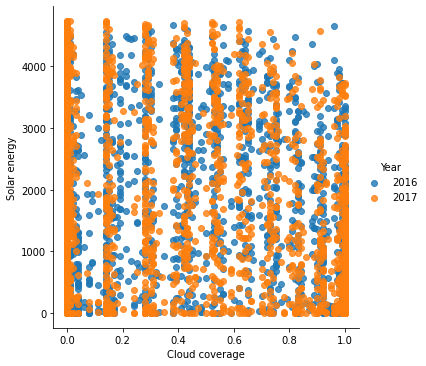

In [ ]:
sns.lmplot(x="Cloud coverage", y="Solar energy",data=train_dataframe,fit_reg=False, hue='Year')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



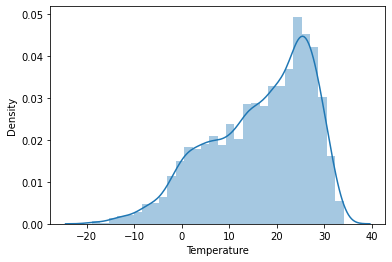

In [ ]:
sns.distplot(train_dataframe["Temperature"]);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



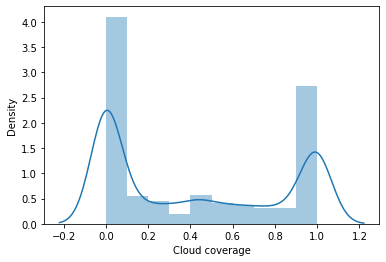

In [ ]:
sns.distplot(train_dataframe["Cloud coverage"]);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



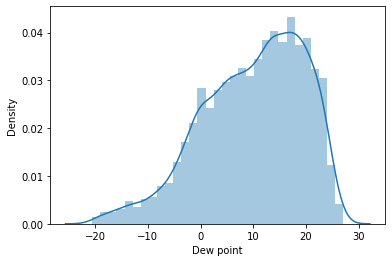

In [ ]:
sns.distplot(train_dataframe["Dew point"]);

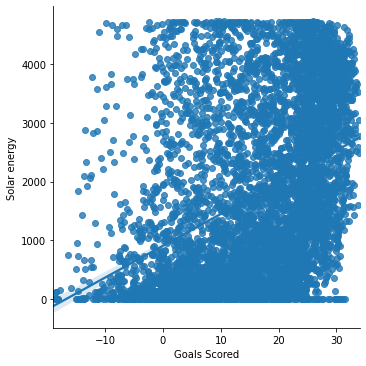

In [ ]:
sns.lmplot(x="Temperature", y="Solar energy",data=train_dataframe,fit_reg=True,)
plt.xlabel("Goals Scored")
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(train_dataframe, x='Cloud coverage', y='Temperature', z='Solar energy', color="Year",symbol="Year" )
fig.show()

## Preparing data for Machine Learning Algorithm

In [ ]:
train_data, train_labels, dev_data, dev_labels, test_data, test_labels, scale_factor = import_data(train_dataframe, dev_dataframe, test_dataframe)


time_steps = 1
assert(train_data.shape[0] % time_steps == 0)

X_train = train_data.copy()
X_dev = dev_data.copy()
X_test = test_data.copy()
Y_train = train_labels.copy()
Y_dev = dev_labels.copy()
Y_test = test_labels.copy()

# Model Training and Performance Evaluation

## Functionalize model fittting

In [ ]:
from math import sqrt
mse_list=dict()
gpred=[]

def FitModel(X,Y,algo_name,algorithm,gridSearchParams,cv):
    global gpred
    np.random.seed(10)
    x_train_L,x_test_L,y_train_L,y_test_L = train_test_split(X,Y, test_size = 0.05)
    
    
    grid = GridSearchCV(
        estimator=algorithm,
        param_grid=gridSearchParams,
        cv=cv,  verbose=1, n_jobs=-1)
    
    
    grid_result = grid.fit(x_train_L, y_train_L)
    best_params = grid_result.best_params_
    pred = grid_result.predict(x_test_L)
    
   # metrics =grid_result.gr
    #print(pred)
    #pickle.dump(grid_result,open(algo_name,'wb'))
    label_list=Y_test.tolist()
    

    print('Best Params :',best_params)
    print('Root Mean squared error {}'.format(sqrt(mean_squared_error(y_test_L, pred))))
    
    pred_test = grid_result.predict(X_test)
    gpred= pred_test
    diff = label_list - pred_test
    res_df = pd.concat([pd.Series(pred_test),pd.Series(label_list),pd.Series(diff)],axis=1)
    res_df.columns = ['Prediction','Original Data','Diff']
    print()
    print('******************** R2 Score on ORIGINAL TEST DATA **************************')
    print("Test r2_score: ", r2_score(label_list, pred_test) )
    print('******************** MSE BASED on ORIGINAL TEST DATA **************************')
    print('Root Mean squared error {}'.format(sqrt(mean_squared_error(label_list, pred_test))))
    mse_list[algo_name]=sqrt(mean_squared_error(label_list, pred_test))
    print('******************** Prediction vs ORIGINAL TEST DATA **************************')
    print(res_df.head())

    
pd.options.display.float_format = '{:.2f}'.format

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
param ={
            'n_estimators': [50]#100,150, 300,500, 700,1000, 2000],
           
        }
FitModel(X_train,Y_train,'Random Forest',RandomForestRegressor(),param,cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Best Params : {'n_estimators': 50}
Root Mean squared error 0.1292211383826173

******************** R2 Score on ORIGINAL TEST DATA **************************
Test r2_score:  0.7983664610829443
******************** MSE BASED on ORIGINAL TEST DATA **************************
Root Mean squared error 0.13730040353439055
******************** Prediction vs ORIGINAL TEST DATA **************************
   Prediction  Original Data  Diff
0        0.28           0.27 -0.01
1        0.66           0.64 -0.03
2        0.03           0.05  0.02
3        0.13           0.13 -0.00
4        0.39           0.35 -0.04


## SVR

In [ ]:
from sklearn.svm import SVR
param ={
            'C': [0.1],#, 1, 100, 1000],
            'gamma': [0.0001]#, 0.001, 0.005, 0.1, 1, 3, 5]
        }
FitModel(X_train,Y_train,'SVR',SVR(),param,cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Best Params : {'C': 0.1, 'gamma': 0.0001}
Root Mean squared error 0.31499939780228

******************** R2 Score on ORIGINAL TEST DATA **************************
Test r2_score:  0.016118666434350115
******************** MSE BASED on ORIGINAL TEST DATA **************************
Root Mean squared error 0.3032925816859137
******************** Prediction vs ORIGINAL TEST DATA **************************
   Prediction  Original Data  Diff
0        0.31           0.27 -0.04
1        0.34           0.64  0.30
2        0.31           0.05 -0.25
3        0.30           0.13 -0.18
4        0.32           0.35  0.03


## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


param ={
            'max_depth':[2]#,3,4,5]
        }
FitModel(X_train, Y_train,'GradientBoostingRegressor',GradientBoostingRegressor(),param,cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Best Params : {'max_depth': 2}
Root Mean squared error 0.15199272919183182

******************** R2 Score on ORIGINAL TEST DATA **************************
Test r2_score:  0.7326496551330617
******************** MSE BASED on ORIGINAL TEST DATA **************************
Root Mean squared error 0.15809961111817533
******************** Prediction vs ORIGINAL TEST DATA **************************
   Prediction  Original Data  Diff
0        0.23           0.27  0.04
1        0.62           0.64  0.01
2        0.00           0.05  0.05
3        0.06           0.13  0.07
4        0.32           0.35  0.03


## Recurrrent Neural Network

In [ ]:
X_train = np.reshape(train_data, (train_data.shape[0] // time_steps, time_steps, train_data.shape[1]))
X_dev = np.reshape(dev_data, (dev_data.shape[0] // time_steps, time_steps, dev_data.shape[1]))
X_test = np.reshape(test_data, (test_data.shape[0] // time_steps, time_steps, test_data.shape[1]))
Y_train = np.reshape(train_labels, (train_labels.shape[0] // time_steps, time_steps, 1))
Y_dev = np.reshape(dev_labels, (dev_labels.shape[0] // time_steps, time_steps, 1))
Y_test = np.reshape(test_labels, (test_labels.shape[0] // time_steps, time_steps, 1))

In [ ]:
#Construt and return Keras RNN model
def build_model(init_type = 'glorot_uniform', optimizer = 'adam', num_features = 12):
    model = Sequential()
    layers = [num_features, 64, 64, 1, 1]
    model.add(keras.layers.LSTM(
        layers[0],
        input_shape = (None, num_features),
        return_sequences=True))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.LSTM(
        layers[1],
        kernel_initializer = init_type,
        return_sequences=True
        #bias_initializer = 'zeros'
    ))
    model.add(keras.layers.Dropout(0.2))

    model.add(Dense(
        layers[2], activation='tanh',
        kernel_initializer=init_type,
        input_shape = (None, 1)
        ))
    model.add(Dense(
        layers[3]))

    model.add(Activation("relu"))

    #Alternative parameters:
    #momentum = 0.8
    #learning_rate = 0.1
    #epochs = 100
    #decay_rate = learning_rate / 100
    #sgd = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    #model.compile(loss="binary_crossentropy", optimizer=sgd)
    rms = keras.optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=1e-08, decay=0.01)
    model.compile(loss="mean_squared_error", optimizer=optimizer)

    return model

In [ ]:

model = build_model('glorot_uniform', 'adam')

#Standard vanilla LSTM model

model_fit_epochs = 100
print("X_train shape: ",X_train.shape, " Y_train shape: ",Y_train.shape)

model.fit(
    X_train, Y_train,
    batch_size = 16, epochs = model_fit_epochs)
trainset_predicted = model.predict(X_train)
devset_predicted = model.predict(X_dev)
testset_predicted = model.predict(X_test)

print(trainset_predicted.shape, Y_train.shape)

print("Train r2_score: ", r2_score(trainset_predicted.reshape(-1, 1), Y_train.reshape(-1, 1)) )
print("Dev r2_score: ", r2_score(devset_predicted.reshape(-1, 1), Y_dev.reshape(-1, 1)) )
print("Test r2_score: ", r2_score(testset_predicted.reshape(-1, 1), Y_test.reshape(-1, 1)))

print("Train MSE: ", mse(trainset_predicted, Y_train) * scale_factor * scale_factor)
print("Dev MSE: ", mse(devset_predicted, Y_dev) * scale_factor * scale_factor)
print("Test MSE: ", mse(testset_predicted, Y_test) * scale_factor * scale_factor)

write_to_csv(trainset_predicted,'nn_trainset_prediction.csv')
write_to_csv(devset_predicted,'nn_devset_prediction.csv')
write_to_csv(testset_predicted, 'nn_testset_prediction.csv')